<a href="https://colab.research.google.com/github/Sarik123-long/Estimating-Treatment-Effects-with-Propensity-Score-Matching/blob/main/Estimating_Treatment_Effects_with_Propensity_Score_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install causalml statsmodels seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1


In [ ]:
!pip install --upgrade causalml statsmodels seaborn

In [ ]:
!pip show causalml

Name: causalml
Version: 0.15.5
Summary: Python Package for Uplift Modeling and Causal Inference with Machine Learning Algorithms
Home-page: https://github.com/uber/causalml
Author: Huigang Chen, Totte Harinen, Jeong-Yoon Lee, Jing Pan, Mike Yung, Zhenyu Zhao
Author-email: 
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: dill, forestci, graphviz, lightgbm, matplotlib, numpy, packaging, pandas, pathos, pydotplus, scikit-learn, scipy, seaborn, shap, statsmodels, tqdm, xgboost
Required-by: 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd

# Suppose "treatment" is your binary column (0=control, 1=treatment)
# and "X_covariates" are_


# Causal ML
from causalml.match import NearestNeighborMatch


In [ ]:
from google.colab import files
uploaded = files.upload()   # this opens a file chooser



Saving archive (23).zip to archive (23).zip


In [ ]:
import zipfile
import io

# replace 'yourfile.zip' with your uploaded file name
with zipfile.ZipFile("archive (23).zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")   # extracts to "dataset" folder

In [ ]:
import pandas as pd

# Assuming the csv file inside the zip is named 'ab_test.csv'
try:
    df = pd.read_csv("dataset/ab_test.csv")
    display(df.head())
except FileNotFoundError:
    print("Could not find 'ab_test.csv' in the 'dataset' folder. Please check the extracted files.")

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors
df["treatment"] = df["con_treat"].map({"control":0, "treatment":1}).astype(int)
y = df["converted"]   # outcome
T = df["treatment"]   # treatment indicator
X_covariates = pd.get_dummies(df[["page"]], drop_first=True)
X_covariates = sm.add_constant(X_covariates, has_constant='add') # Use has_constant='add' for robustness

# Convert boolean columns to float
for col in X_covariates.columns:
    if X_covariates[col].dtype == bool:
        X_covariates[col] = X_covariates[col].astype(float)

# Check data types before passing to Logit
print("Data type of T:", T.dtype)
print("Data types of X_covariates:\n", X_covariates.dtypes)


logit_model = sm.Logit(T, X_covariates)
logit_result = logit_model.fit(disp=0)
df["propensity_score"] = logit_result.predict(X_covariates)

print("Propensity Scores Assigned:")
print(df[["treatment", "propensity_score"]].head())
treated = df[df["treatment"] == 1]
control = df[df["treatment"] == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[["propensity_score"]])
distances, indices = nn.kneighbors(treated[["propensity_score"]])

# Build matched dataset
matched_control = control.iloc[indices.flatten()].copy()
matched_treated = treated.reset_index(drop=True)
matched_data = pd.concat([matched_treated, matched_control]).reset_index(drop=True)

print("Matched Dataset Shape:", matched_data.shape)
treated_outcome = matched_treated["converted"].mean()
control_outcome = matched_control["converted"].mean()

ate = treated_outcome - control_outcome
print("Average Treatment Effect (ATE):", ate)

Data type of T: int64
Data types of X_covariates:
 const            float64
page_old_page    float64
dtype: object
Propensity Scores Assigned:
   treatment  propensity_score
0          0          0.013346
1          0          0.013346
2          1          0.986906
3          1          0.986906
4          0          0.013346
Matched Dataset Shape: (294552, 8)
Average Treatment Effect (ATE): -0.8677381243379777


In [ ]:
print("Average Treatment Effect (ATE) from PSM:", ate)

Average Treatment Effect (ATE) from PSM: -0.8677381243379777


In [ ]:
display(matched.columns)

Index(['id', 'time', 'con_treat', 'page', 'converted', 'group_binary'], dtype='object')

In [ ]:
# Estimate Average Treatment Effect
treated_outcome = matched_data[matched_data["treatment"] == 1]["converted"].mean()
control_outcome = matched_data[matched_data["treatment"] == 0]["converted"].mean()

ate = treated_outcome - control_outcome
print(f"Conversion rate (Treated): {treated_outcome:.4f}")
print(f"Conversion rate (Control): {control_outcome:.4f}")
print(f"Estimated Average Treatment Effect (ATE): {ate:.4f}")


Conversion rate (Treated): 0.1189
Conversion rate (Control): 0.9867
Estimated Average Treatment Effect (ATE): -0.8677


/tmp/ipython-input-3698379897.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["treatment"]==1]["propensity_score"], label="Treated", shade=True)
/tmp/ipython-input-3698379897.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["treatment"]==0]["propensity_score"], label="Control", shade=True)
/tmp/ipython-input-3698379897.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(matched_data[matched_data["treatment"]==1]["propensity_score"], label="Treated", shade=True)
/tmp/ipython-input-3698379897.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an e

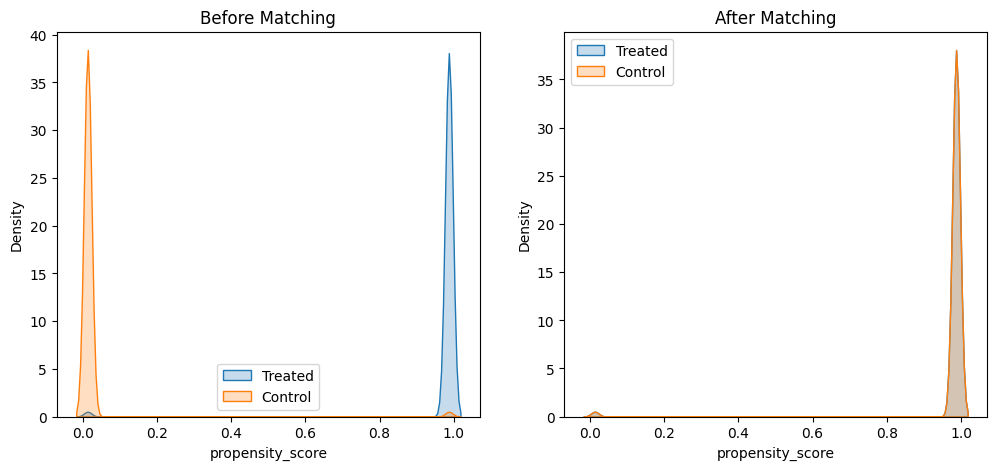

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Before Matching
plt.subplot(1,2,1)
sns.kdeplot(df[df["treatment"]==1]["propensity_score"], label="Treated", shade=True)
sns.kdeplot(df[df["treatment"]==0]["propensity_score"], label="Control", shade=True)
plt.title("Before Matching")
plt.legend()

# After Matching
plt.subplot(1,2,2)
sns.kdeplot(matched_data[matched_data["treatment"]==1]["propensity_score"], label="Treated", shade=True)
sns.kdeplot(matched_data[matched_data["treatment"]==0]["propensity_score"], label="Control", shade=True)
plt.title("After Matching")
plt.legend()

plt.show()


In [ ]:
!pip install gradio -q

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import io
import os

# Define the path to the extracted data file
DATA_PATH = "dataset/ab_test.csv"

def perform_psm_analysis():
    # Ensure the dataset directory exists and the file is extracted
    if not os.path.exists("dataset"):
        os.makedirs("dataset")
        # Assuming the zip file is still available from the previous upload
        zip_file_name = "archive (23).zip" # Replace with the actual zip file name if different
        if os.path.exists(zip_file_name):
             with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
                zip_ref.extractall("dataset")
        else:
            return "Error: Zip file not found. Please ensure 'archive (23).zip' is in the current directory.", None, None


    if not os.path.exists(DATA_PATH):
         return f"Error: Data file '{DATA_PATH}' not found after extraction.", None, None


    try:
        df = pd.read_csv(DATA_PATH)
    except FileNotFoundError:
        return f"Error: Data file '{DATA_PATH}' not found.", None, None
    except Exception as e:
        return f"Error loading data: {e}", None, None


    # -------------------------
    # 1. Prepare Treatment & Outcome
    # -------------------------
    df["treatment"] = df["con_treat"].map({"control":0, "treatment":1}).astype(int)
    y = df["converted"]   # outcome
    T = df["treatment"]   # treatment indicator

    # -------------------------
    # 2. Estimate Propensity Scores (Logistic Regression)
    # -------------------------
    # Example: use 'page' as covariate (you can add more)
    X_covariates = pd.get_dummies(df[["page"]], drop_first=True)
    X_covariates = sm.add_constant(X_covariates, has_constant='add') # Use has_constant='add' for robustness

    # Convert boolean columns to float
    for col in X_covariates.columns:
        if X_covariates[col].dtype == bool:
            X_covariates[col] = X_covariates[col].astype(float)

    try:
        logit_model = sm.Logit(T, X_covariates)
        logit_result = logit_model.fit(disp=0)
        df["propensity_score"] = logit_result.predict(X_covariates)
    except Exception as e:
        return f"Error estimating propensity scores: {e}", None, None


    # -------------------------
    # 3. Nearest Neighbor Matching
    # -------------------------
    treated = df[df["treatment"] == 1]
    control = df[df["treatment"] == 0]

    try:
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(control[["propensity_score"]])
        distances, indices = nn.kneighbors(treated[["propensity_score"]])

        # Build matched dataset
        matched_control = control.iloc[indices.flatten()].copy()
        matched_treated = treated.reset_index(drop=True)
        matched_data = pd.concat([matched_treated, matched_control]).reset_index(drop=True)
    except Exception as e:
        return f"Error during matching: {e}", None, None


    # -------------------------
    # 4. Estimate Average Treatment Effect (ATE)
    # -------------------------
    try:
        treated_outcome = matched_treated["converted"].mean()
        control_outcome = matched_control["converted"].mean()
        ate = treated_outcome - control_outcome
        ate_text = f"Average Treatment Effect (ATE): {ate:.4f}"
    except Exception as e:
        return f"Error calculating ATE: {e}", None, None


    # -------------------------
    # 5. Visualize Propensity Score Distribution
    # -------------------------
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Before Matching
    sns.kdeplot(df[df["treatment"]==1]["propensity_score"], label="Treated", fill=True, ax=axes[0])
    sns.kdeplot(df[df["treatment"]==0]["propensity_score"], label="Control", fill=True, ax=axes[0])
    axes[0].set_title("Propensity Score Distribution Before Matching")
    axes[0].legend()

    # After Matching
    sns.kdeplot(matched_data[matched_data["treatment"]==1]["propensity_score"], label="Treated", fill=True, ax=axes[1])
    sns.kdeplot(matched_data[matched_data["treatment"]==0]["propensity_score"], label="Control", fill=True, ax=axes[1])
    axes[1].set_title("Propensity Score Distribution After Matching")
    axes[1].legend()

    plt.tight_layout()
    plot_output = fig # Return the figure object

    return ate_text, plot_output, matched_data # Return ATE text, plot, and matched data (optional)

# Create Gradio Interface
# The inputs will be none as data is loaded from a fixed path
# The outputs will be the ATE text, the plot, and potentially the matched data
interface = gr.Interface(
    fn=perform_psm_analysis,
    inputs=[], # No inputs needed as data is loaded internally
    outputs=[
        gr.Textbox(label="Average Treatment Effect (ATE)"),
        gr.Plot(label="Propensity Score Distribution"),
        gr.Dataframe(label="Matched Data (Head)", visible=False) # Optional: display matched data head
    ],
    title="Propensity Score Matching and ATE Estimation",
    description="Estimates Average Treatment Effect using Nearest Neighbor Propensity Score Matching."
)

# Launch the Gradio app
interface.launch(inline=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e6dd4652c5af020cff.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
